In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import os
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator, InterpolatedUnivariateSpline

In [2]:
import shap
import spektral
from spektral.layers import GCNConv

c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.neighbors import NearestNeighbors

In [4]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [47]:
# regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [52]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [8]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [69]:
def readTrainData():
    path = 'sources/'
    df = pd.read_csv(path+'AppML_InitialProject_train.csv')
    return df
trainDf = readTrainData()

In [10]:
trainDf

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,p_eta,p_phi,p_charge,p_Truth_isElectron,p_truth_pt,p_truth_phi,p_truth_eta,p_Truth_Energy,p_truth_pdgId,p_truth_parent_pdgId
0,29.49,0.105563,0.111953,0.000000,0.020473,0.746226,0.671689,0.000000,0.000000,0.063020,...,-1.425603,-0.859392,-1.0,1,2815.96020,-0.828581,-1.425959,6198.1055,11,22
1,17.50,0.001889,0.001663,0.007252,0.009059,0.944349,0.967633,0.955249,0.135955,0.059219,...,-0.380698,-1.014216,-1.0,1,39207.48000,-1.014038,-0.380727,42083.5980,11,23
2,30.50,-0.001041,-0.001294,0.006346,0.008852,0.976413,0.959573,0.937885,0.171204,-0.105151,...,0.591333,2.983345,1.0,1,64328.51600,2.981821,0.592576,75957.2800,-11,23
3,46.49,0.000606,0.002833,0.005985,0.009785,0.950910,0.945615,0.966444,0.263183,-0.026020,...,1.006222,0.503709,1.0,1,46312.54700,0.503773,1.006411,71814.3700,-11,23
4,31.50,0.024148,0.067781,0.034671,0.009486,0.797810,0.670594,0.087876,0.373575,0.219026,...,-1.674565,1.063436,-1.0,1,858.65717,1.060842,-1.676498,2375.8310,11,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,36.50,0.492974,1.262969,0.025889,0.015685,0.472843,0.684885,0.287160,0.304126,-0.148706,...,0.540303,-3.105240,1.0,0,32911.66400,-3.105209,0.540659,37840.4920,211,2
179996,31.50,0.076596,0.572484,0.117248,0.009608,0.958072,0.936306,0.076313,0.274991,-0.109284,...,0.541794,1.783658,-1.0,0,13656.11700,1.783581,0.541314,15706.8370,-211,-213
179997,30.50,1.674750,2.193961,0.019816,0.011431,0.787651,0.670452,0.343338,0.112708,0.017916,...,0.140798,-3.116873,-1.0,0,5216.26300,-3.116861,0.141633,5270.5180,-211,223
179998,36.50,0.040680,0.043097,0.008589,0.012814,0.619827,0.598550,0.342507,0.298415,-0.095350,...,1.321953,-0.292104,1.0,0,18433.30000,-0.292308,1.321826,37022.7270,211,113


In [72]:
def readTestData():
    path = 'sources/'
    df_classification = pd.read_csv(path+'AppML_InitialProject_test_classification.csv')
    df_clustering = pd.read_csv(path+'AppML_InitialProject_test_clustering.csv')
    df_regression = pd.read_csv(path+'AppML_InitialProject_test_regression.csv')
    return df_classification, df_clustering, df_regression
testDf_clsf, testDf_clst, testDf_regs = readTestData()

In [12]:
testDf_clsf

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr0,pX_E7x11_Lr1,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge
0,36.50,0.000463,-0.000876,0.002665,0.009376,0.937129,0.959152,0.984819,0.326582,0.238975,...,1868.9042,16364.933,33013.040,76.07219,1868.9042,16364.933,20527.746,0.325806,1.086726,1.0
1,48.50,0.050439,0.069607,0.028404,0.013048,0.700572,0.590812,0.000000,0.000000,-0.000000,...,0.0000,50501.242,182841.720,19097.24800,0.0000,50501.242,11949.609,-2.450711,0.354888,-1.0
2,32.50,0.002050,0.003029,0.007395,0.010444,0.963112,0.959066,0.985446,0.353189,0.666636,...,905.5605,13357.994,22515.666,314.40604,905.5605,13357.994,35849.570,0.140523,0.733514,-1.0
3,28.50,0.027664,0.043439,0.011525,0.011258,0.962601,0.948064,0.984326,0.345560,0.240108,...,0.0000,32864.360,61438.790,975.66034,0.0000,32864.360,18349.436,1.948463,-2.287875,1.0
4,20.49,-0.008994,-0.011444,0.007584,0.010042,0.965167,0.955182,0.993133,0.268595,0.139726,...,1970.9218,19733.762,51706.180,1139.15390,1970.9218,19761.928,54046.035,-0.726814,2.317220,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,34.50,0.450859,0.494188,0.000000,0.000000,0.000800,-0.004000,0.000000,0.000000,0.079010,...,26463.0250,36277.290,36799.094,154.07170,26463.0250,33269.820,15200.653,1.475503,-0.021296,1.0
59996,29.49,0.265472,0.720422,0.008196,0.010941,0.811148,0.919864,0.031265,0.258551,0.131573,...,5135.4090,11495.376,27522.310,170.00873,5135.4090,11495.376,12442.076,-0.858835,-1.879149,1.0
59997,49.50,0.192758,0.273979,0.126550,0.013108,0.923015,0.936289,0.000163,0.128086,0.324599,...,8782.7180,9258.149,55382.840,12358.93300,8782.7180,9258.149,44505.652,-1.699267,1.073709,-1.0
59998,35.50,0.345104,0.436920,0.034847,0.012072,0.802757,0.834948,0.000000,0.000000,-0.000000,...,0.0000,47620.070,217042.200,13176.30400,0.0000,47620.070,53259.473,2.468021,-2.511265,-1.0


In [13]:
testDf_clst

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr0,pX_E7x11_Lr1,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge
0,48.50,0.002621,0.003149,0.000421,0.012095,0.873118,0.837550,0.000000,0.000000,0.231180,...,26052.62100,18763.9260,13017.211,-57.970287,26052.62100,18820.9820,48257.5500,-1.505234,1.175829,-1.0
1,39.49,0.014003,0.008869,0.041638,0.010281,0.925357,0.940242,0.950630,0.135817,0.303750,...,0.00000,18765.0780,119595.300,6125.241700,0.00000,18734.8180,33935.6500,1.995196,-1.292367,1.0
2,25.49,0.007870,0.009702,0.004270,0.010424,0.939269,0.958781,0.984077,0.391043,0.041206,...,4592.48900,21492.4510,28992.730,596.587800,4592.48900,21492.4510,44557.0900,-0.797741,-1.067770,-1.0
3,28.50,0.001414,-0.004248,0.012807,0.013539,0.916596,0.913783,0.991349,0.516933,-0.000000,...,0.00000,50264.5740,51692.957,-31.530766,0.00000,50264.5740,9718.2190,-2.276100,1.133550,1.0
4,23.50,0.000988,-0.023321,0.010335,0.010201,0.816869,0.921899,0.941022,0.390446,1.016616,...,688.87744,42935.8480,68867.445,590.925900,688.87744,42935.8480,25790.2190,1.871118,-0.622213,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,41.49,0.228431,0.522523,0.004807,0.015567,0.755933,0.467267,0.545339,0.469139,0.102263,...,2119.91600,19943.8500,43843.484,2144.287000,2119.91600,19865.7100,13294.7360,-0.125354,1.901233,-1.0
19996,33.50,0.046517,0.324909,0.006538,0.011492,0.845218,0.831077,0.085903,0.220015,-0.015957,...,3875.20310,7355.2130,26095.656,1062.750000,3875.20310,7355.2130,12671.7760,1.015306,2.975697,1.0
19997,20.49,0.903955,1.183762,0.073063,0.013042,0.804634,0.686622,0.804377,0.249756,0.024105,...,2255.14300,6096.4795,17283.645,4235.365000,2255.14300,6096.4795,33278.6700,0.653617,0.767755,-1.0
19998,37.50,0.381709,0.706533,0.019395,0.011556,0.852819,0.860969,0.110009,0.221309,-0.039300,...,3007.39580,15878.5160,46878.400,4535.643000,3007.39580,15878.5160,3054.2612,0.528555,-1.317966,-1.0


In [14]:
testDf_regs

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr0,pX_E7x11_Lr1,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge
0,36.50,-0.006231,-0.004756,0.000000,0.011021,0.939902,0.933349,0.940145,0.240089,0.742557,...,9555.348000,12439.4170,30005.940,30.267273,9555.348000,12439.4170,27331.0250,-1.356775,2.437287,1.0
1,27.50,0.069768,0.066464,0.008597,0.010425,0.947139,0.956537,0.954305,0.378152,0.053620,...,-32.166813,7150.0110,11357.543,223.495700,-32.166813,7150.0110,14839.9460,0.758425,0.424543,1.0
2,38.50,0.031475,0.032103,0.006010,0.009790,0.971168,0.975648,0.982716,0.261825,0.348544,...,930.292700,13870.4400,37771.043,235.996550,930.292700,13870.4400,47934.7800,0.451583,1.543324,1.0
3,44.49,0.255715,0.598475,0.023568,0.017368,0.759111,0.413124,0.000000,0.000000,-0.000000,...,0.000000,30461.0350,101239.040,17743.662000,0.000000,30461.0350,1547.0653,2.386935,-2.541257,-1.0
4,46.49,-0.002943,0.000832,0.005014,0.009650,0.978518,0.975219,0.989922,0.400065,0.328410,...,716.887100,16007.3790,25491.777,280.913300,716.887100,16007.3790,38393.7200,-0.595902,2.444494,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,45.49,0.639871,0.931700,0.047565,0.014313,0.751563,0.481971,0.049648,0.222836,0.182798,...,1919.307000,5069.9614,12153.055,1186.884900,2981.303000,3690.7695,13794.3930,-0.908004,-2.500148,-1.0
39996,23.50,0.035678,0.035608,0.006525,0.013475,0.553298,0.772175,0.485771,0.300058,-0.134290,...,12320.759000,9364.2210,18286.041,3545.511200,12481.400000,10613.4300,24288.5330,1.532268,1.387485,-1.0
39997,30.50,0.506169,1.408881,0.004859,0.012234,0.749204,0.798801,0.289237,0.297742,-0.078994,...,3829.177200,10531.5870,22682.910,922.046450,4448.633300,8834.5300,46904.3700,0.871931,0.338847,-1.0
39998,34.50,0.029772,0.015480,0.013480,0.012181,0.855929,0.755831,0.303872,0.201922,-0.044859,...,0.000000,29014.9770,87093.380,2459.278600,0.000000,28916.5590,14215.0450,1.921771,-0.448903,1.0


In [15]:
def compare(test, train):
    setTest = set(test.columns)
    setTrain = set(train.columns)
    tags = setTrain - setTest
    return tags

In [16]:
missingTags = compare(testDf_clsf, trainDf) | compare(testDf_regs, trainDf) | compare(testDf_clst, trainDf)
missingTags


{'p_Truth_Energy',
 'p_Truth_isElectron',
 'p_truth_eta',
 'p_truth_parent_pdgId',
 'p_truth_pdgId',
 'p_truth_phi',
 'p_truth_pt'}

* `FNNClassifier` builds a TensorFlow feedforward neural network classifier
* `CNNClassifier` builds a TensorFlow convolution neural network classifier
* `GNNClassifier` builds a TensorFlow graph neural network classifier
* it can be used as other sklearn classifiers or xgboost having these public functions(methods)
  * `fit`
  * `predict`

In [17]:
class FNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_classes, epochs=50):
        self.num_classes = num_classes
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        # Check if the model exists and if input_dim has changed
        if self.model is None or self.input_dim != X.shape[1]:
            self.input_dim = X.shape[1]  # Update the input_dim based on current X
            # Rebuild the model
            self.model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(128, activation='relu', input_shape=(self.input_dim,)),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(self.num_classes, activation='softmax')
            ])
            self.model.compile(optimizer='adam',
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).argmax(axis=1)


In [18]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # Initialize first GCN layer
        self.conv2 = GCNConv(16, num_classes)  # Initialize second GCN layer

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # Pass data through first GCN layer
        x = F.relu(x)  # Apply ReLU non-linearity
        x = self.conv2(x, edge_index)  # Pass data through second GCN layer
        return F.log_softmax(x, dim=1)

In [19]:
class GNNClassifier:
    def __init__(self, num_classes, num_features, epochs=50):
        self.num_classes = num_classes
        self.num_features = num_features
        self.epochs = epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = GCN(num_features, num_classes).to(self.device)

    def fit(self, loader):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        for epoch in range(self.epochs):
            for batch in loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                output = self.model(batch.x, batch.edge_index)
                loss = F.nll_loss(output, batch.y)
                loss.backward()
                optimizer.step()

    def predict(self, loader):
        self.model.eval()
        all_predictions = []
        for batch in loader:
            batch = batch.to(self.device)
            output = self.model(batch.x, batch.edge_index)
            pred = output.max(dim=1)[1]
            all_predictions.extend(pred.cpu().numpy())
        return all_predictions

In [20]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, C=0.5, solver='lbfgs'),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt'),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=1.0),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, n_estimators=100, learning_rate=0.1, max_depth=3, objective='binary:logistic'),
    'FNN': FNNClassifier(num_classes=2, epochs=50),
    # 'GNN': GNNClassifier(num_classes=2, num_features=140, epochs=50),
}
classifiers.keys()

dict_keys(['LogisticRegression', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'XGBoost', 'FNN'])

In [57]:
allFeatures = ["averageInteractionsPerCrossing",
            "p_Rhad1",
            "p_Rhad",
            "p_f3",
            "p_weta2",
            "p_Rphi",
            "p_Reta",
            "p_Eratio",
            "p_f1",
            "p_TRTPID",
            "p_numberOfInnermostPixelHits",
            "p_numberOfPixelHits",
            "p_numberOfSCTHits",
            "p_numberOfTRTHits",
            "p_TRTTrackOccupancy",
            "p_numberOfTRTXenonHits",
            "p_z0",
            "p_d0",
            "p_sigmad0",
            "p_dPOverP",
            "p_deltaEta1",
            "p_deltaPhiRescaled2",
            "p_etcone20",
            "p_etcone30",
            "p_etcone40",
            "p_ptcone20",
            "p_ptcone30",
            "p_ptcone40",
            "p_ptPU30",
            "p_vertex",
            "pX_E7x7_Lr2",
            "pX_E7x7_Lr3",
            "pX_E_Lr0_HiG",
            "pX_E_Lr0_MedG",
            "pX_E_Lr1_HiG",
            "pX_E_Lr1_LowG",
            "pX_E_Lr1_MedG",
            "pX_E_Lr2_HiG",
            "pX_E_Lr2_LowG",
            "pX_E_Lr2_MedG",
            "pX_E_Lr3_HiG",
            "pX_E_Lr3_MedG",
            "pX_MultiLepton",
            "pX_OQ",
            "pX_ambiguityType",
            "pX_asy1",
            "pX_author",
            "pX_barys1",
            "pX_core57cellsEnergyCorrection",
            "pX_deltaEta0",
            "pX_deltaEta1",
            "pX_deltaEta2",
            "pX_deltaEta3",
            "pX_deltaPhi0",
            "pX_deltaPhi1",
            "pX_deltaPhi2",
            "pX_deltaPhi3",
            "pX_deltaPhiFromLastMeasurement",
            "pX_deltaPhiRescaled0",
            "pX_deltaPhiRescaled1",
            "pX_deltaPhiRescaled3",
            "pX_e1152",
            "pX_e132",
            "pX_e235",
            "pX_e255",
            "pX_e2ts1",
            "pX_ecore",
            "pX_emins1",
            "pX_etcone20",
            "pX_etcone30",
            "pX_etcone40",
            "pX_f1core",
            "pX_f3core",
            "pX_maxEcell_energy",
            "pX_maxEcell_gain",
            "pX_maxEcell_time",
            "pX_maxEcell_x",
            "pX_maxEcell_y",
            "pX_maxEcell_z",
            "pX_nCells_Lr0_HiG",
            "pX_nCells_Lr0_MedG",
            "pX_nCells_Lr1_HiG",
            "pX_nCells_Lr1_LowG",
            "pX_nCells_Lr1_MedG",
            "pX_nCells_Lr2_HiG",
            "pX_nCells_Lr2_LowG",
            "pX_nCells_Lr2_MedG",
            "pX_nCells_Lr3_HiG",
            "pX_nCells_Lr3_MedG",
            "pX_neflowisol20",
            "pX_neflowisol30",
            "pX_neflowisol40",
            "pX_neflowisolcoreConeEnergyCorrection",
            "pX_pos",
            "pX_pos7",
            "pX_poscs1",
            "pX_poscs2",
            "pX_ptcone20",
            "pX_ptcone30",
            "pX_ptcone40",
            "pX_ptconecoreTrackPtrCorrection",
            "pX_ptvarcone20",
            "pX_ptvarcone30",
            "pX_ptvarcone40",
            "pX_r33over37allcalo",
            "pX_topoetcone20",
            "pX_topoetcone20ptCorrection",
            "pX_topoetcone30",
            "pX_topoetcone30ptCorrection",
            "pX_topoetcone40",
            "pX_topoetcone40ptCorrection",
            "pX_topoetconecoreConeEnergyCorrection",
            "pX_weta1",
            "pX_widths1",
            "pX_wtots1",
            "pX_e233",
            "pX_e237",
            "pX_e2tsts1",
            "pX_ehad1",
            "pX_emaxs1",
            "pX_fracs1",
            "pX_DeltaE",
            "pX_E3x5_Lr0",
            "pX_E3x5_Lr1",
            "pX_E3x5_Lr2",
            "pX_E3x5_Lr3",
            "pX_E5x7_Lr0",
            "pX_E5x7_Lr1",
            "pX_E5x7_Lr2",
            "pX_E5x7_Lr3",
            "pX_E7x11_Lr0",
            "pX_E7x11_Lr1",
            "pX_E7x11_Lr2",
            "pX_E7x11_Lr3",
            "pX_E7x7_Lr0",
            "pX_E7x7_Lr1",
            "p_pt_track",
            "p_eta",
            "p_phi",
            "p_charge",]

* `getCM`: Calculates the confusion matrix, accuracy, and fraction of wrong predictions.
  * `predictions`: Array of predicted labels
  * `true_labels`: Array of true labels
  * returns Tuple containing the confusion matrix, accuracy, and fraction of wrong predictions

In [21]:
def getCM(predictions, true_labels):
    N = np.zeros((2, 2), dtype=int)
    
    for i in range(len(predictions)):
        N[true_labels[i]][predictions[i]] += 1

    fracWrong = float(N[0][1] + N[1][0]) / float(len(true_labels))
    accuracy = 1.0 - fracWrong
    
    return N, accuracy, fracWrong

In [22]:
def getConfusionMatrix(predictions, true_labels):
    return confusion_matrix(true_labels, predictions)

In [23]:
def showCM(predictions, true_labels):
    N, accuracy, fracWrong = getCM(predictions, true_labels)
    print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
    print("  First number in parenthesis is the estimate, second is the MC truth:")
    print("  True-Negative (0,0)  = ", N[0][0])
    print("  False-Negative (0,1) = ", N[0][1])
    print("  False-Positive (1,0) = ", N[1][0])
    print("  True-Positive (1,1)  = ", N[1][1])
    print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
    print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)

In [24]:
def saveToCsv(predictions, filename):
    df = pd.DataFrame(predictions)
    df.to_csv(filename, index=False)

* `getEdgeIndex` creates an edge_index tensor using the k-nearest neighbors approach.
* Parameters:
  * `X` (np.array): Feature matrix of shape (num_samples, num_features)
  * `k` (int): Number of nearest neighbors to connect each node with
* returns `edge_index` (torch.tensor): Tensor of shape (2, num_edges) for use in GNN

In [25]:
def getEdgeIndex(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Create edge index array
    edge_index = []
    num_nodes = X.shape[0]
    for i in range(num_nodes):
        for j in range(1, k+1):  # start from 1 to avoid self-loops
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])  # add reverse connection for undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

In [65]:
def runClsfFeaturesKernel(trainDf, key, Nfeatures=20):
    classifier = classifiers[key]
    # X_train = trainDf.drop(missingTags, axis=1)
    X_train = trainDf[allFeatures]
    y_train = trainDf['p_Truth_isElectron']
    
    classifier.fit(X_train.values, y_train.values)

    # Tree Explainer for XGB
    if classifier == classifiers['XGBoost']:
        explainer = shap.TreeExplainer(classifier)
    else:
        explainer = shap.KernelExplainer(classifier.predict, shap.sample(X_train, 100))  # Using a sample for approximation

    shap_values = explainer.shap_values(shap.sample(X_train, 100))  # Again, using a sample for practicality

    shap_summaries = np.abs(shap_values).mean(axis=0)

    indices = np.argsort(shap_summaries)[::-1]

    top_features = X_train.columns[indices[:Nfeatures]].tolist()

    shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=Nfeatures)

    return top_features

In [27]:
# print(runClsfFeatures(trainDf, classifiers['AdaBoost'], Nfeatures=20))
# 5 min 40 sec

In [28]:
def makeVariableCsv(features, filename):
    path = 'solutions/'
    df = pd.DataFrame(features)
    df.to_csv(path+filename, index=False, header=False)

In [29]:
# features_LR = runClsfFeaturesKernel(trainDf, 'LogisticRegression', Nfeatures=20)
# 1 min 30 sec
# 4 min 30 sec
# 1 min 30 sec

In [30]:
# features_RF = runClsfFeaturesKernel(trainDf, 'RandomForest', Nfeatures=20)
#  4 m 30 s
# 13 m 12 s
# 5 min

In [31]:
# features_AB = runClsfFeaturesKernel(trainDf, 'AdaBoost', Nfeatures=20)
# 7 m 50 s
# 8 m 

In [32]:
# features_GB = runClsfFeaturesKernel(trainDf, 'GradientBoosting', Nfeatures=20)
# 3 min
# 12 min 30 sec

In [33]:
# features_XGB = runClsfFeaturesKernel(trainDf, 'XGBoost', Nfeatures=20)
# TreeExplainer : 10 sec
# 1.7 sec

In [34]:
# features_FNN = runClsfFeaturesKernel(trainDf, 'FNN', Nfeatures=20)
# 47 min
# 9 min 30 sec

In [35]:
trainDf.shape

(180000, 147)

In [36]:
# makeVariableCsv(features_LR, 'Classification_CyanYongHoJo_LogisticRegression_VariableList.csv')
# makeVariableCsv(features_RF, 'Classification_CyanYongHoJo_RandomForest_VariableList.csv')
# makeVariableCsv(features_AB, 'Classification_CyanYongHoJo_AdaBoost_VariableList.csv')
# makeVariableCsv(features_GB, 'Classification_CyanYongHoJo_GradientBoosting_VariableList.csv')
# makeVariableCsv(features_XGB, 'Classification_CyanYongHoJo_XGBoost_VariableList.csv')
# makeVariableCsv(features_FNN, 'Classification_CyanYongHoJo_FNN_VariableList.csv')

In [37]:
def getClsfFeatures():
    features = {}
    for classifier in classifiers.keys():
        path = 'solutions/Classification_CyanYongHoJo_' + classifier + '_VariableList.csv'
        features[classifier] = pd.read_csv(path, header=None).values.flatten().tolist()
    return features

In [38]:
selected_features = getClsfFeatures()

In [39]:
# for i in getFeatures()['LogisticRegression']:
#     print(i)

for i in selected_features['FNN']:
    print(i)

p_charge
pX_OQ
pX_deltaEta0
pX_core57cellsEnergyCorrection
pX_barys1
pX_author
pX_asy1
pX_ambiguityType
pX_MultiLepton
pX_deltaEta2
pX_E_Lr3_MedG
pX_E_Lr3_HiG
pX_E_Lr2_MedG
pX_E_Lr2_LowG
pX_E_Lr2_HiG
pX_E_Lr1_MedG
pX_deltaEta1
pX_deltaEta3
p_phi
pX_e1152


In [40]:
# trainDf = readTrainData()
# testDf_clsf, testDf_clst, testDf_regs = readTestData()
# # 30 sec

In [41]:
trainDf['p_Truth_isElectron']

0         1
1         1
2         1
3         1
4         1
         ..
179995    0
179996    0
179997    0
179998    0
179999    0
Name: p_Truth_isElectron, Length: 180000, dtype: int64

In [42]:
def runClsfCore(trainDf, testDf, key, filename):
    selFeatures = selected_features[key]
    # if 'p_Truth_isElectron' in selFeatures:
    #     selFeatures.remove('p_Truth_isElectron')
    
    commonFeatures = [feature for feature in selFeatures if feature in testDf.columns]
    X_train = trainDf[commonFeatures].values
    y_train = trainDf['p_Truth_isElectron'].values

    X_test = testDf[commonFeatures].values

    classifier = classifiers[key]
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    saveToCsv(y_pred, filename)

    return y_pred


In [43]:
def runClsf():
    y_preds = {}
    for key in classifiers.keys():
        print(f'--------------------{key}-------------------------')
        y_pred = runClsfCore(trainDf, testDf_clsf, key, f'solutions/Classification_CyanYongHoJo_{key}.csv')
        y_preds[key] = y_pred
        print(f"Predictions for {key} saved.")
    return y_preds

In [44]:
# y_preds = runClsf()

In [50]:
class FNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, num_units=128, epochs=50):
        self.num_units = num_units
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        K.clear_session()  # Clear existing TensorFlow/Keras session
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(self.num_units, activation='relu', input_shape=(X.shape[1],)),
            tf.keras.layers.Dense(self.num_units // 2, activation='relu'),
            tf.keras.layers.Dense(1)  # Output layer for regression (no activation function)
        ])
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        self.model.fit(X, y, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()  # Flatten if the output is multidimensional

In [51]:
regressors = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt'),
    'AdaBoost': AdaBoostRegressor(n_estimators=50, learning_rate=1.0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror'),
    'FNN': FNNRegressor(epochs=50),
}

In [54]:
def checkMatch():
    expected_columns = set(allFeatures)
    resulting_columns = set(trainDf.drop(missingTags, axis=1).columns)

    # Check if sets are equal
    columns_match = expected_columns == resulting_columns
    print(f"Do the columns match? {columns_match}")

In [55]:
checkMatch()

Do the columns match? True


In [74]:
def getTrueElectron():
    return trainDf[trainDf['p_Truth_isElectron']==1]

In [76]:
trainDfElectron = getTrueElectron()
trainDfElectron

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,p_eta,p_phi,p_charge,p_Truth_isElectron,p_truth_pt,p_truth_phi,p_truth_eta,p_Truth_Energy,p_truth_pdgId,p_truth_parent_pdgId
0,29.49,0.105563,0.111953,0.000000,0.020473,0.746226,0.671689,0.000000,0.000000,0.063020,...,-1.425603,-0.859392,-1.0,1,2815.96020,-0.828581,-1.425959,6198.1055,11,22
1,17.50,0.001889,0.001663,0.007252,0.009059,0.944349,0.967633,0.955249,0.135955,0.059219,...,-0.380698,-1.014216,-1.0,1,39207.48000,-1.014038,-0.380727,42083.5980,11,23
2,30.50,-0.001041,-0.001294,0.006346,0.008852,0.976413,0.959573,0.937885,0.171204,-0.105151,...,0.591333,2.983345,1.0,1,64328.51600,2.981821,0.592576,75957.2800,-11,23
3,46.49,0.000606,0.002833,0.005985,0.009785,0.950910,0.945615,0.966444,0.263183,-0.026020,...,1.006222,0.503709,1.0,1,46312.54700,0.503773,1.006411,71814.3700,-11,23
4,31.50,0.024148,0.067781,0.034671,0.009486,0.797810,0.670594,0.087876,0.373575,0.219026,...,-1.674565,1.063436,-1.0,1,858.65717,1.060842,-1.676498,2375.8310,11,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37795,21.50,-0.003432,-0.000165,0.013303,0.008923,0.976566,0.956013,0.984709,0.218947,-0.039420,...,-0.469702,3.071647,1.0,1,39785.13000,3.071871,-0.469999,44260.8750,-11,23
37796,22.50,0.000239,-0.002017,0.006113,0.009205,0.980445,0.959889,0.969011,0.256502,-0.139889,...,-0.371270,1.647501,1.0,1,49854.32000,1.647469,-0.371133,53327.3700,-11,23
37797,49.50,-0.010304,-0.014718,0.000000,-0.000014,0.933516,1.044198,0.000000,0.000000,0.147924,...,1.447067,-1.567863,-1.0,1,38424.50000,-1.568063,1.447102,86186.6700,11,23
37798,40.49,-0.011447,-0.014197,0.004176,0.010338,0.939820,0.964426,0.964783,0.347332,0.288003,...,0.415594,-0.664441,1.0,1,45036.43400,-0.666050,0.415493,48980.1100,-11,23


In [77]:
trainDfElectron['p_Truth_Energy']

0         6198.1055
1        42083.5980
2        75957.2800
3        71814.3700
4         2375.8310
            ...    
37795    44260.8750
37796    53327.3700
37797    86186.6700
37798    48980.1100
37799    54621.8160
Name: p_Truth_Energy, Length: 37800, dtype: float64

In [78]:
def runRegrFeaturesKernel(key, Nfeatures=25):
    regressor = regressors[key]
    X_train = trainDfElectron[allFeatures]
    y_train = trainDfElectron['p_Truth_Energy']
    
    regressor.fit(X_train.values, y_train.values)

    if 'Tree' in str(type(regressor)):
        explainer = shap.TreeExplainer(regressor)
        shap_values = explainer.shap_values(X_train)
    else:
        explainer = shap.KernelExplainer(regressor.predict, shap.sample(X_train, 100))
        shap_values = explainer.shap_values(shap.sample(X_train, 100))

    shap_summaries = np.abs(shap_values).mean(axis=0)

    indices = np.argsort(shap_summaries)[::-1]

    top_features = X_train.columns[indices[:Nfeatures]].tolist()

    shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=Nfeatures)

    return top_features

In [79]:
def runRegressionFeatures():
    for key in regressors.keys():
        print(f'--------------------{key}-------------------------')
        features = runRegrFeaturesKernel(key, Nfeatures=25)
        makeVariableCsv(features, f'Regression_CyanYongHoJo_{key}_VariableList.csv')
        print(f"Features for {key} saved.")

--------------------LinearRegression-------------------------


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


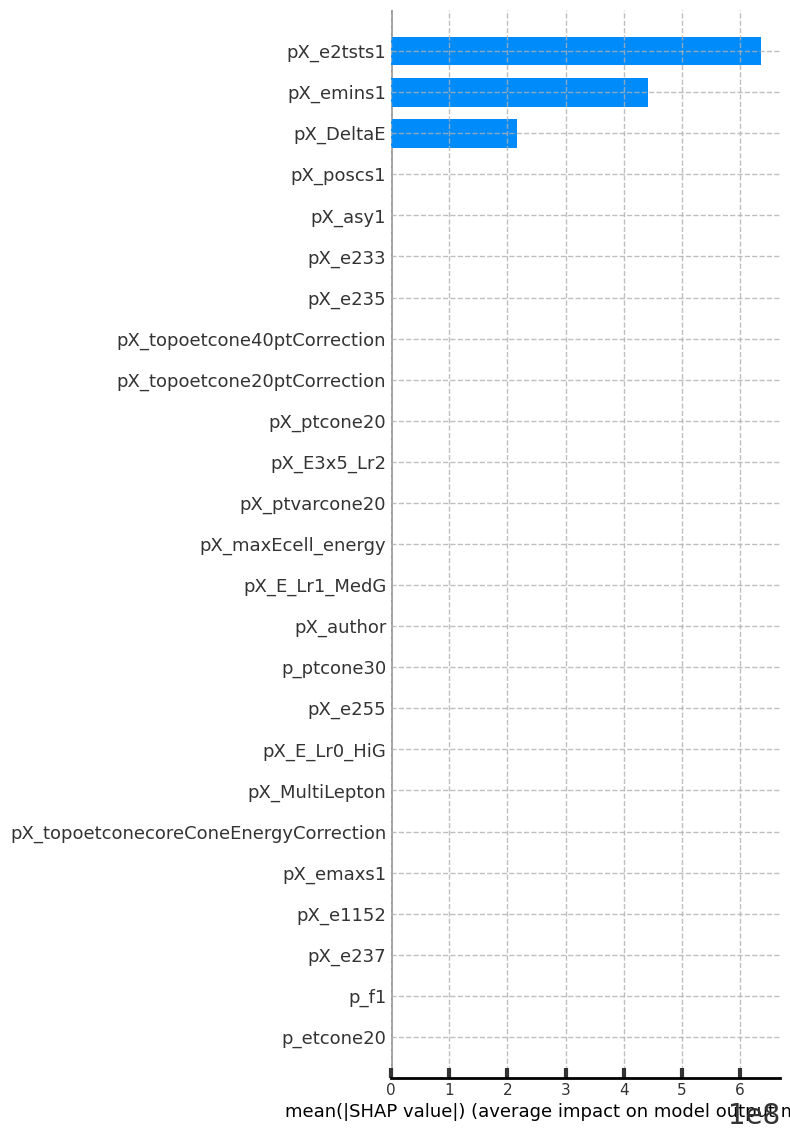

Features for LinearRegression saved.
--------------------RandomForest-------------------------


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


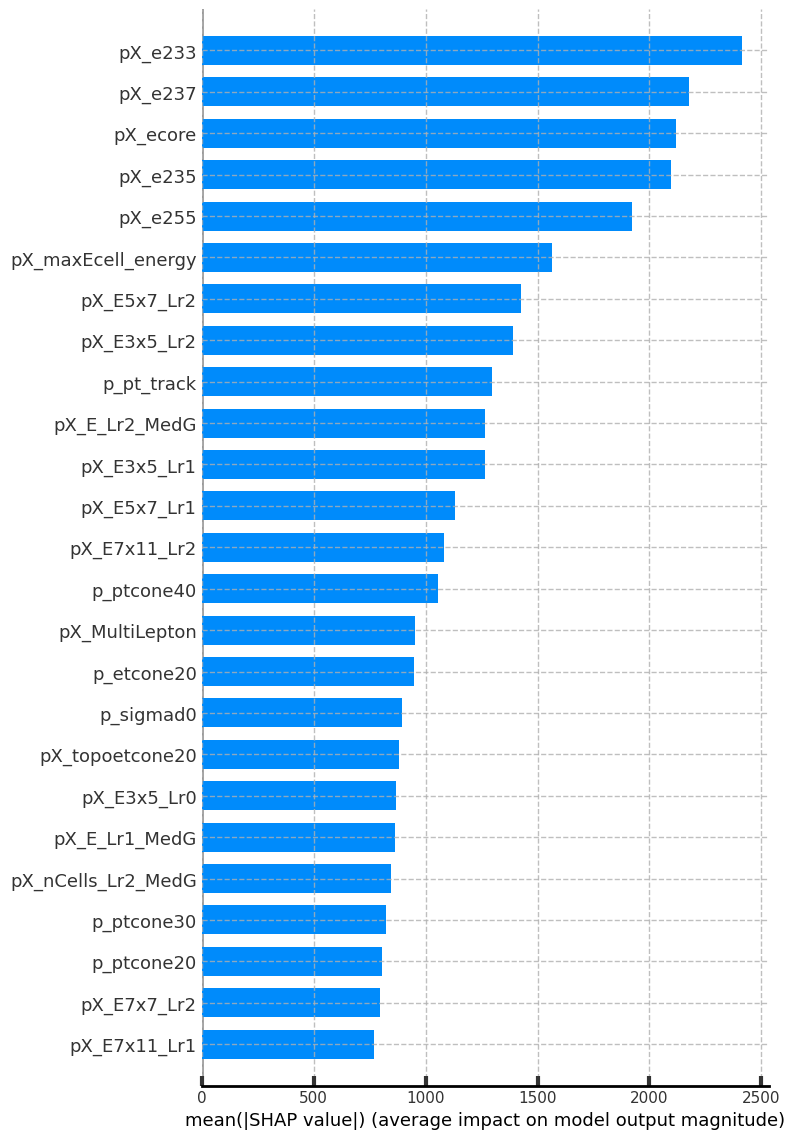

Features for RandomForest saved.
--------------------AdaBoost-------------------------


100%|██████████| 100/100 [05:29<00:00,  3.29s/it]


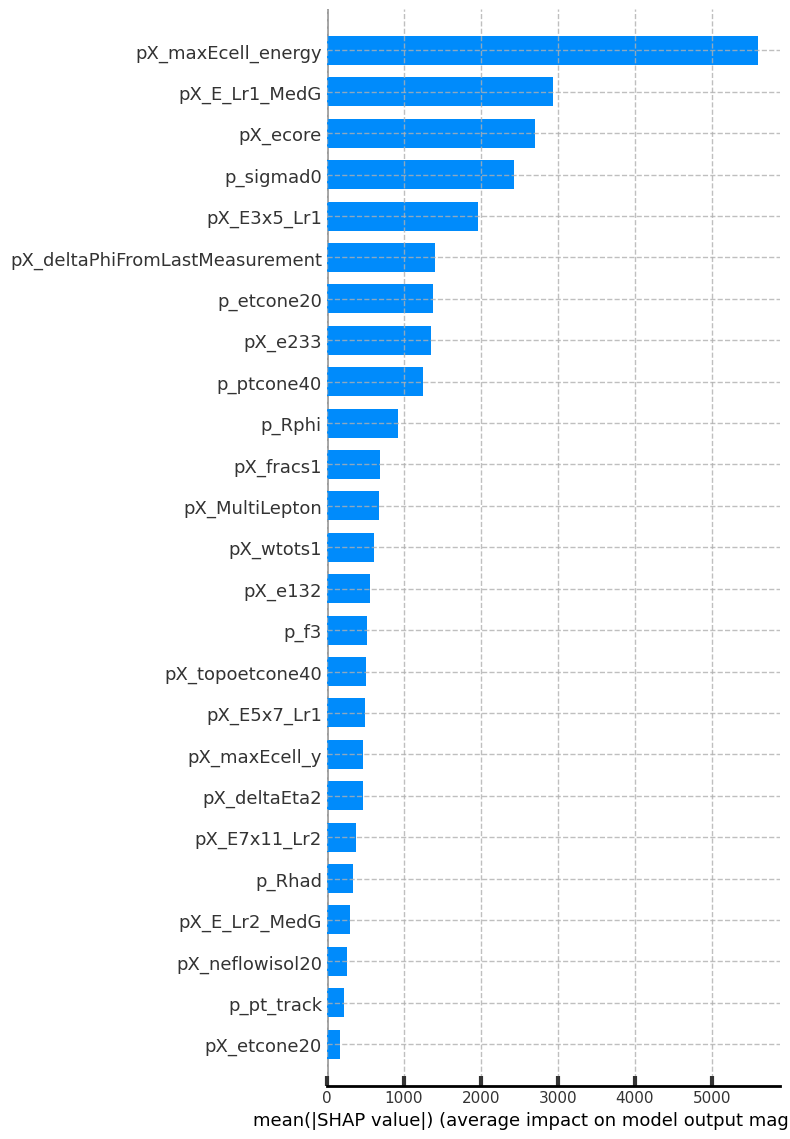

Features for AdaBoost saved.
--------------------GradientBoosting-------------------------


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


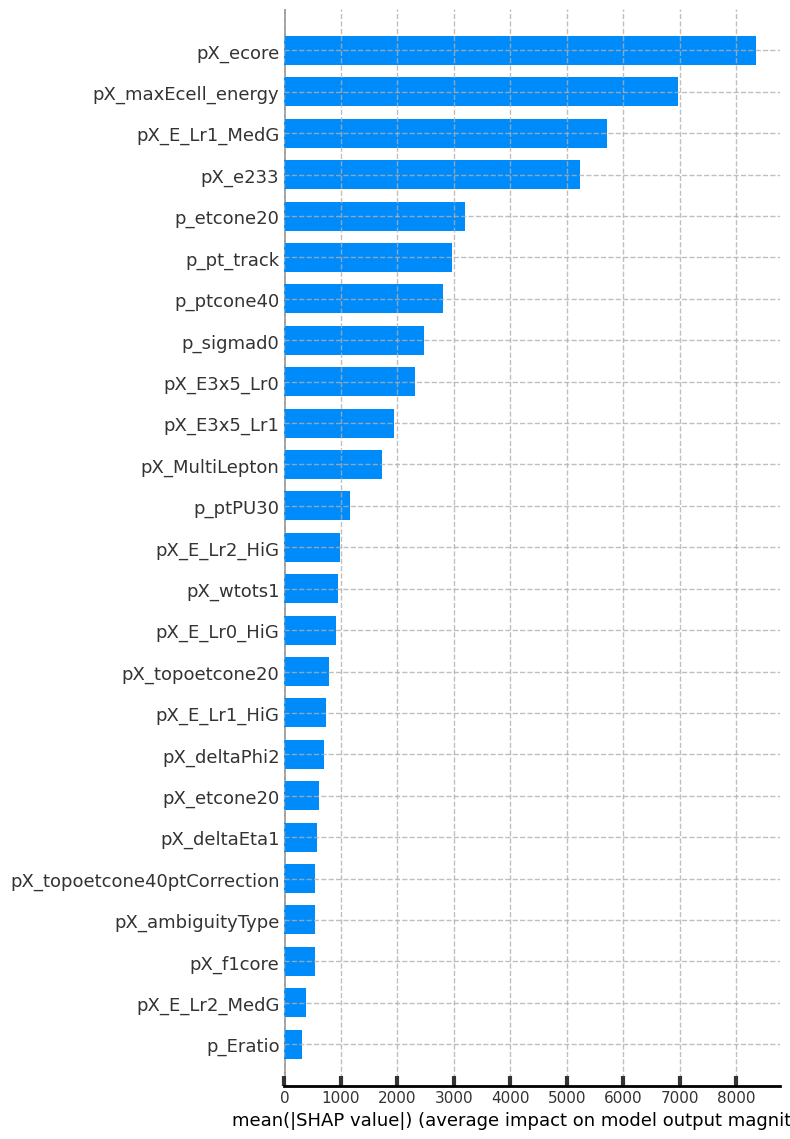

Features for GradientBoosting saved.
--------------------XGBoost-------------------------


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


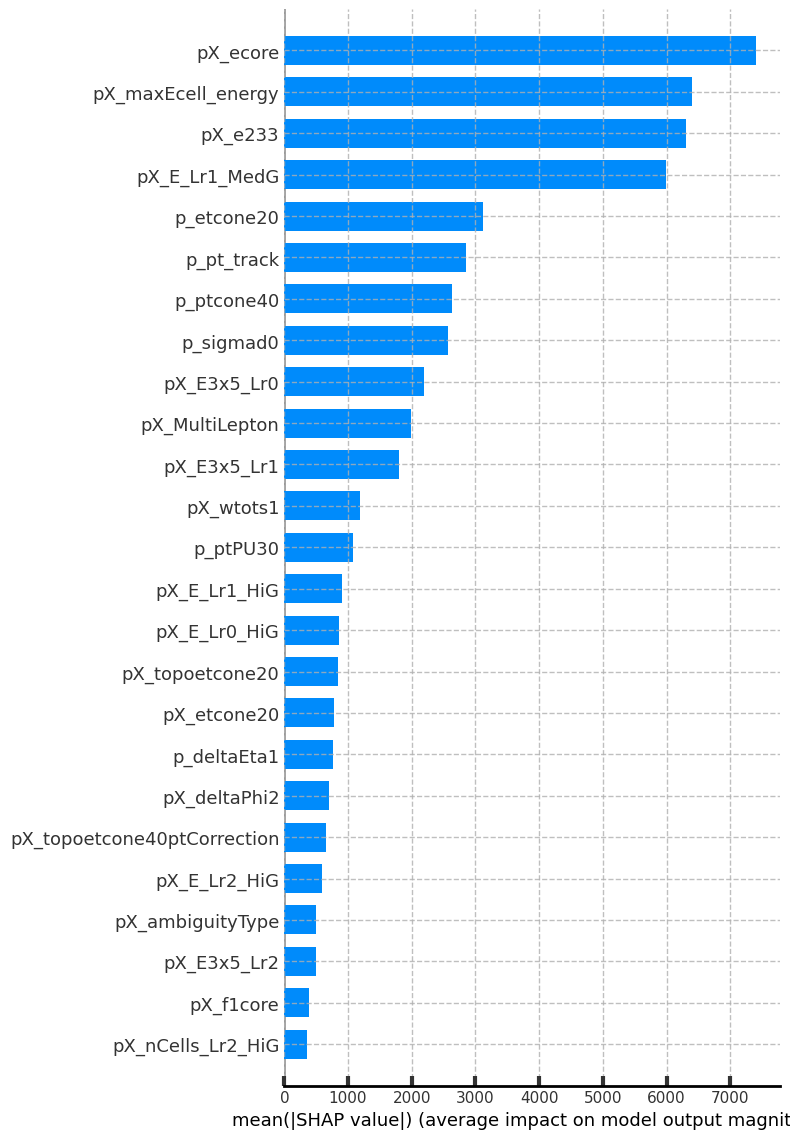

Features for XGBoost saved.
--------------------FNN-------------------------



c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


  1%|          | 1/100 [00:04<06:40,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


  2%|▏         | 2/100 [00:07<06:15,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


  3%|▎         | 3/100 [00:11<06:08,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 307us/step


  4%|▍         | 4/100 [00:15<05:59,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


  5%|▌         | 5/100 [00:18<05:53,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 309us/step


  6%|▌         | 6/100 [00:22<05:48,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


  7%|▋         | 7/100 [00:28<06:52,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 307us/step


  8%|▊         | 8/100 [00:32<06:26,  4.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step


  9%|▉         | 9/100 [00:35<06:09,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 309us/step


 10%|█         | 10/100 [00:39<05:55,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 11%|█         | 11/100 [00:43<05:44,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 12%|█▏        | 12/100 [00:46<05:34,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step


 13%|█▎        | 13/100 [00:50<05:31,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 14%|█▍        | 14/100 [00:54<05:24,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 309us/step


 15%|█▌        | 15/100 [00:58<05:18,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 16%|█▌        | 16/100 [01:01<05:12,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step


 17%|█▋        | 17/100 [01:05<05:09,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 18%|█▊        | 18/100 [01:09<05:04,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 19%|█▉        | 19/100 [01:12<05:00,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 20%|██        | 20/100 [01:16<04:56,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step


 21%|██        | 21/100 [01:20<04:53,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 22%|██▏       | 22/100 [01:24<04:50,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 23%|██▎       | 23/100 [01:27<04:45,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step


 24%|██▍       | 24/100 [01:31<04:42,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 25%|██▌       | 25/100 [01:35<04:37,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 26%|██▌       | 26/100 [01:38<04:33,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 27%|██▋       | 27/100 [01:44<05:18,  4.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 28%|██▊       | 28/100 [01:48<04:58,  4.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 307us/step


 29%|██▉       | 29/100 [01:52<04:47,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 30%|███       | 30/100 [01:55<04:35,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 31%|███       | 31/100 [01:59<04:26,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 32%|███▏      | 32/100 [02:03<04:18,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 307us/step


 33%|███▎      | 33/100 [02:06<04:11,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 309us/step


 34%|███▍      | 34/100 [02:10<04:06,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 35%|███▌      | 35/100 [02:14<04:01,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 36%|███▌      | 36/100 [02:17<03:56,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 362us/step


 37%|███▋      | 37/100 [02:22<04:04,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 38%|███▊      | 38/100 [02:25<03:57,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 39%|███▉      | 39/100 [02:29<03:50,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 40%|████      | 40/100 [02:33<03:44,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 41%|████      | 41/100 [02:36<03:39,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 42%|████▏     | 42/100 [02:40<03:34,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 43%|████▎     | 43/100 [02:44<03:29,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 44%|████▍     | 44/100 [02:47<03:25,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 45%|████▌     | 45/100 [02:51<03:21,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 46%|████▌     | 46/100 [02:55<03:19,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 47%|████▋     | 47/100 [02:58<03:15,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 48%|████▊     | 48/100 [03:02<03:11,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 49%|████▉     | 49/100 [03:06<03:07,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 297us/step


 50%|█████     | 50/100 [03:09<03:03,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 307us/step


 51%|█████     | 51/100 [03:13<02:59,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 52%|█████▏    | 52/100 [03:17<02:55,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 53%|█████▎    | 53/100 [03:20<02:52,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 54%|█████▍    | 54/100 [03:24<02:48,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 55%|█████▌    | 55/100 [03:28<02:45,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step


 56%|█████▌    | 56/100 [03:31<02:42,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 57%|█████▋    | 57/100 [03:35<02:38,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


 58%|█████▊    | 58/100 [03:39<02:34,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 59%|█████▉    | 59/100 [03:43<02:31,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 60%|██████    | 60/100 [03:46<02:27,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step


 61%|██████    | 61/100 [03:50<02:24,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 62%|██████▏   | 62/100 [03:54<02:21,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 63%|██████▎   | 63/100 [03:57<02:16,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


 64%|██████▍   | 64/100 [04:01<02:13,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 65%|██████▌   | 65/100 [04:05<02:08,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 66%|██████▌   | 66/100 [04:08<02:05,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 300us/step


 67%|██████▋   | 67/100 [04:12<02:00,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 68%|██████▊   | 68/100 [04:16<01:57,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 69%|██████▉   | 69/100 [04:22<02:14,  4.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 300us/step


 70%|███████   | 70/100 [04:25<02:03,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 298us/step


 71%|███████   | 71/100 [04:29<01:54,  3.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 300us/step


 72%|███████▏  | 72/100 [04:32<01:48,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 73%|███████▎  | 73/100 [04:36<01:42,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 314us/step


 74%|███████▍  | 74/100 [04:40<01:38,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step


 75%|███████▌  | 75/100 [04:44<01:34,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 299us/step


 76%|███████▌  | 76/100 [04:47<01:29,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step


 77%|███████▋  | 77/100 [04:53<01:40,  4.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step


 78%|███████▊  | 78/100 [04:57<01:32,  4.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 315us/step


 79%|███████▉  | 79/100 [05:01<01:25,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 315us/step


 80%|████████  | 80/100 [05:04<01:19,  3.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step


 81%|████████  | 81/100 [05:08<01:13,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step


 82%|████████▏ | 82/100 [05:12<01:09,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step


 83%|████████▎ | 83/100 [05:16<01:04,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 84%|████████▍ | 84/100 [05:19<01:00,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step


 85%|████████▌ | 85/100 [05:23<00:56,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 315us/step


 86%|████████▌ | 86/100 [05:27<00:52,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 87%|████████▋ | 87/100 [05:30<00:48,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


 88%|████████▊ | 88/100 [05:34<00:44,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step


 89%|████████▉ | 89/100 [05:38<00:40,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 90%|█████████ | 90/100 [05:41<00:37,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step


 91%|█████████ | 91/100 [05:45<00:33,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


 92%|█████████▏| 92/100 [05:49<00:29,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 308us/step


 93%|█████████▎| 93/100 [05:53<00:25,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 94%|█████████▍| 94/100 [05:56<00:22,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 95%|█████████▌| 95/100 [06:00<00:18,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 96%|█████████▌| 96/100 [06:04<00:14,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step


 97%|█████████▋| 97/100 [06:07<00:11,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


 98%|█████████▊| 98/100 [06:11<00:07,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


 99%|█████████▉| 99/100 [06:15<00:03,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step


100%|██████████| 100/100 [06:19<00:00,  3.79s/it]


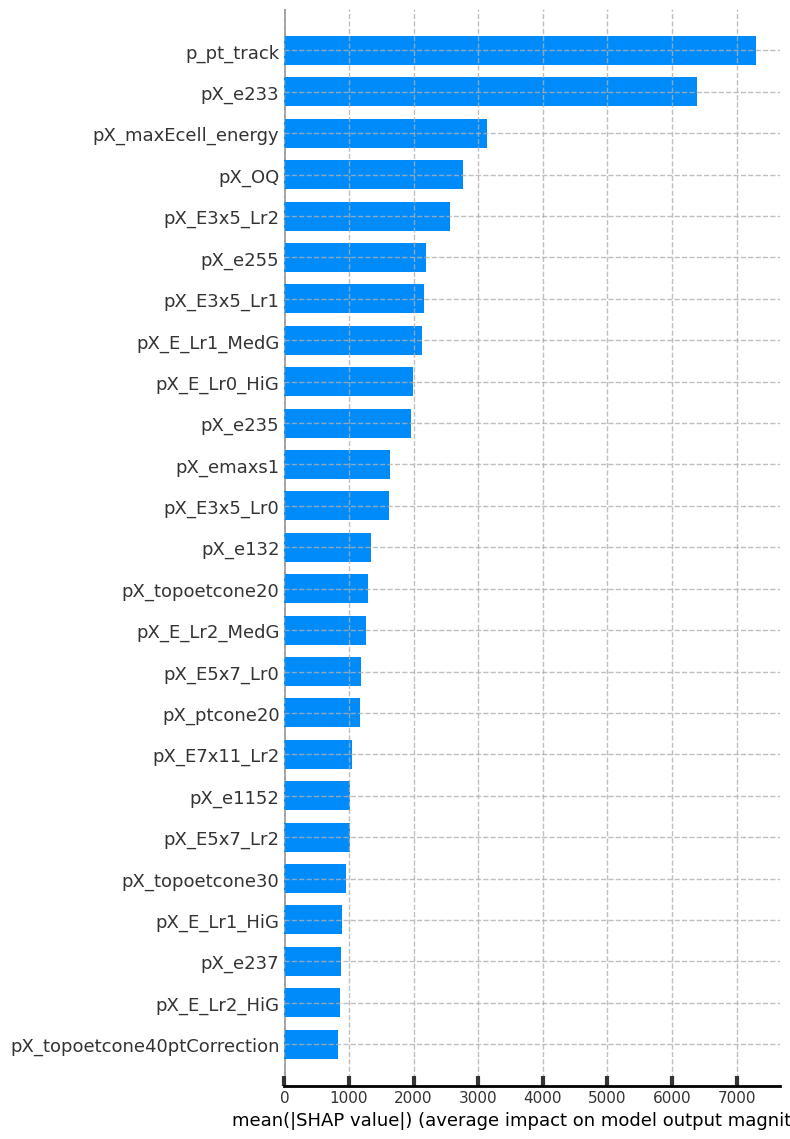

Features for FNN saved.


In [80]:
runRegressionFeatures()
#21 min

In [82]:
def getRrgFeatures():
    features = {}
    for regressor in regressors.keys():
        path = 'solutions/Regression_CyanYongHoJo_' + regressor + '_VariableList.csv'
        features[regressor] = pd.read_csv(path, header=None).values.flatten().tolist()
    return features

In [ ]:
def runRgrCore(trainDfElectron, testDf, key, filename):
    selFeatures = getRrgFeatures()[key]
    
    commonFeatures = [feature for feature in selFeatures if feature in testDf.columns]
    
    X_train = trainDfElectron[commonFeatures].values
    y_train = trainDfElectron['p_Truth_Energy'].values  # Make sure 'p_Truth_Energy' is the correct target column name

    X_test = testDf[commonFeatures].values

    regressor = regressors[key]
    
    regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_test)

    saveToCsv(y_pred, filename)

    return y_pred

In [83]:
def runRgr():
    y_preds = {}
    for key in regressors.keys():
        print(f'--------------------{key}-------------------------')
        y_pred = runRgrCore(trainDfElectron, testDf_regs, key, f'solutions/Regression_CyanYongHoJo_{key}.csv')
        y_preds[key] = y_pred
        print(f"Predictions for {key} saved.")
    return y_preds

In [ ]:
elecEnergyPreds = runRgr()